In [301]:
import pandas as pd

In [302]:
original_df = pd.read_csv("seria_test.csv")
original_df.head()

,Unnamed: 0,timestamp,target
0,0,2018-9-01,196226.415094
1,1,2018-10-01,188835.160112
2,2,2018-11-01,212100.679789
3,3,2018-12-01,259957.325747
4,4,2019-1-01,260000.000000


In [303]:
original_df["timestamp"] = pd.to_datetime(original_df["timestamp"])
original_df["segment"] = "main"
original_df.drop(columns=["Unnamed: 0"], inplace=True)
original_df.head()

,timestamp,target,segment
0,2018-09-01,196226.415094,main
1,2018-10-01,188835.160112,main
2,2018-11-01,212100.679789,main
3,2018-12-01,259957.325747,main
4,2019-01-01,260000.000000,main


In [304]:
from etna.datasets.tsdataset import TSDataset

In [305]:
df = TSDataset.to_dataset(original_df)
df.head()

segment,main
feature,target
timestamp,
2018-09-01,196226.415094
2018-10-01,188835.160112
2018-11-01,212100.679789
2018-12-01,259957.325747
2019-01-01,260000.000000


In [306]:
ts = TSDataset(df, freq="MS")

In [307]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2018-09-01    2021-05-01      33            0


In [308]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2018-09-01,2021-05-01,33,0,1,0,0,0,MS


    Построение графика

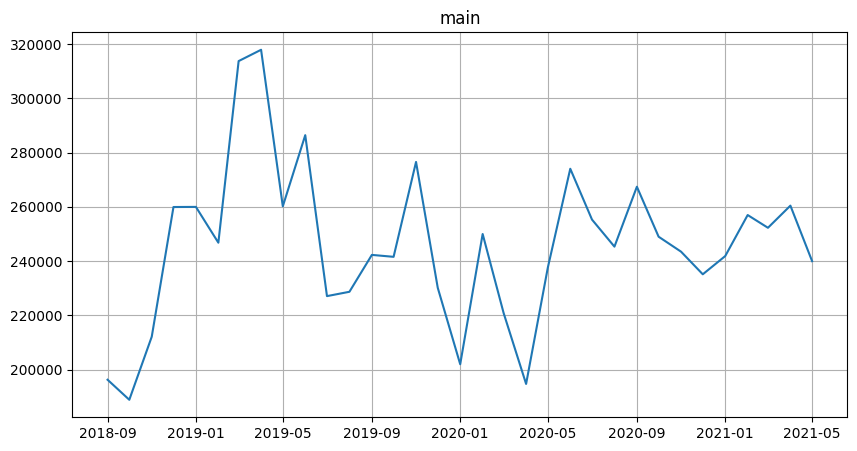

In [309]:
ts.plot()

In [310]:
train_ts, test_ts = ts.train_test_split(
    train_start="2018-09-01",
    train_end="2020-12-01",
    test_start="2021-01-01",
    test_end="2021-05-01",
)

NaiveModel

In [311]:
HORIZON = 5
from etna.models import NaiveModel

# Fit the model
model = NaiveModel(lag=5)
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [312]:
from etna.metrics import SMAPE

In [313]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 3.10064956935474}

In [314]:
from etna.analysis import plot_forecast

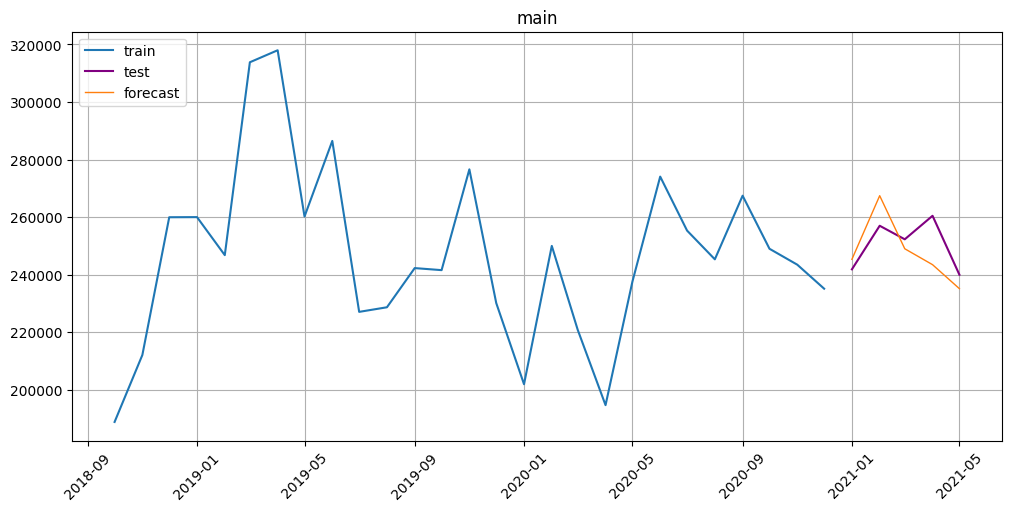

In [315]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=27)

Prophet

In [316]:
from etna.models import ProphetModel
HORIZON = 5
model = ProphetModel()
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa8wdrz5m/liivux1h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa8wdrz5m/iyx0ww3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79973', 'data', 'file=/tmp/tmpa8wdrz5m/liivux1h.json', 'init=/tmp/tmpa8wdrz5m/iyx0ww3p.json', 'output', 'file=/tmp/tmpa8wdrz5m/prophet_model5x4_cfjf/prophet_model-20240114220618.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [317]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 16.976678468073082}

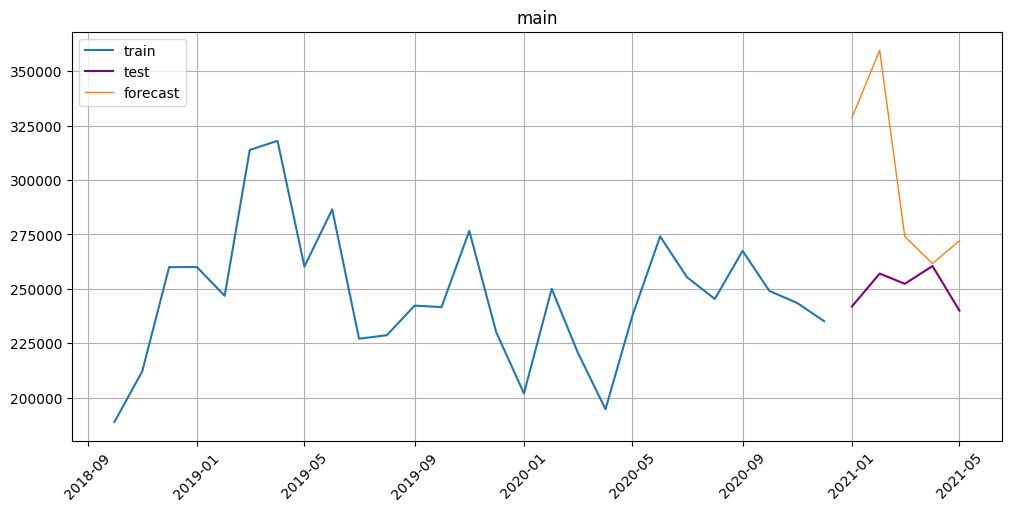

In [318]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=27)

CatBoostMultiSegmentModel

In [319]:
from etna.transforms import LagTransform, LogTransform

lags = LagTransform(in_column="target", lags=[5,10,20])
log = LogTransform(in_column="target")
transforms = [log, lags]
train_ts.fit_transform(transforms)

In [320]:
from etna.models import CatBoostMultiSegmentModel
HORIZON = 5
model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [321]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 2.708407577341869}

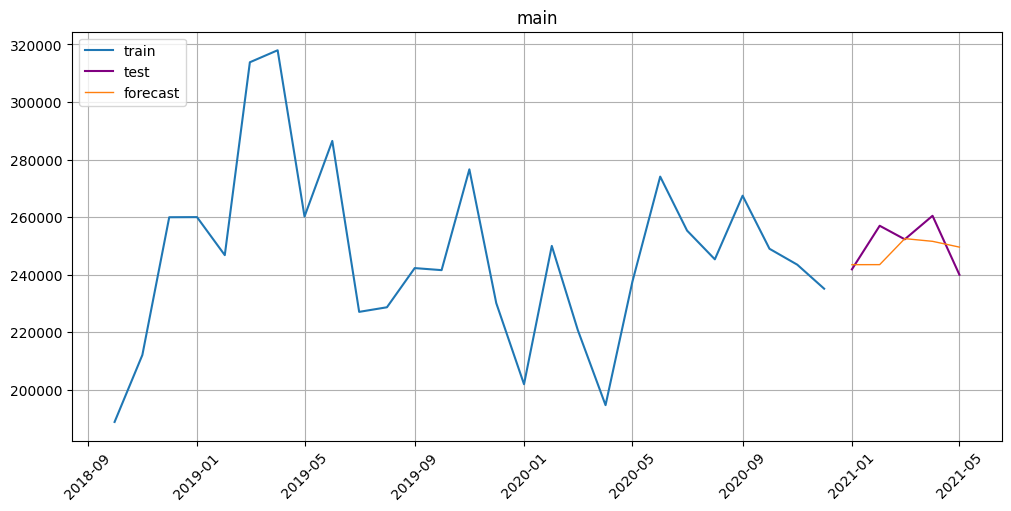

In [322]:
from etna.analysis import plot_forecast

train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=27)